# (MultiFiT) Portuguese Bidirectional Language Model (LM) from scratch
### (architecture 4 QRNN with 1550 hidden parameters by layer, SentencePiece tokenizer and hyperparameters from the MultiFiT method)

**Information**

According to this new article "[MultiFiT: Efficient Multi-lingual Language Model Fine-tuning](https://arxiv.org/abs/1909.04761)" (September 10, 2019), the architecture QRNN and the SentencePiece tokenizer give better results than AWD-LSTM and the spaCy tokenizer respectively. Therefore, they have been used in this notebook to train a Portuguese Bidirectional Language Model on a Wikipedia corpus of 100 millions tokens. 

More, the hyperparameters values given at the end of the article have been used, too.

**Wikipedia corpus**
- download: 193 651 articles of 182 536 221 tokens
- used: 166 580 articles of 100 255 322 tokens

**Hyperparameters values**
- (batch size) bs = 50
- (QRNN) 4 QRNN (default: 3) with 1550 hidden parameters each one (default: 1152)
- (SentencePiece) vocab of 15000 tokens
- (dropout) mult_drop = 0
- (weight decay) wd = 0.01
- (number of training epochs) 10 epochs

## Initialization

In [1]:
from fastai import *
from fastai.text import *
from fastai.callbacks import *

import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
torch.cuda.set_device(0)

In [3]:
import fastai
print(f'fastai: {fastai.__version__}')
print(f'cuda: {torch.cuda.is_available()}')

fastai: 1.0.60
cuda: True


In [4]:
!python -m fastai.utils.show_install



```text
=== Software === 
python        : 3.7.7
fastai        : 1.0.60
fastprogress  : 0.2.2
torch         : 1.4.0
nvidia driver : 440.82
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 8117MB | GeForce GTX 1070

=== Environment === 
platform      : Linux-5.3.0-46-generic-x86_64-with-debian-buster-sid
distro        : #38~18.04.1-Ubuntu SMP Tue Mar 31 04:17:56 UTC 2020
conda env     : fastai
python        : /home/wesley/anaconda3/envs/fastai/bin/python
sys.path      : /mnt/dados/Github/ia-squad/languagemodel
/home/wesley/anaconda3/envs/fastai/lib/python37.zip
/home/wesley/anaconda3/envs/fastai/lib/python3.7
/home/wesley/anaconda3/envs/fastai/lib/python3.7/lib-dynload
/home/wesley/anaconda3/envs/fastai/lib/python3.7/site-packages
/home/wesley/anaconda3/envs/fastai/lib/python3.7/site-packages/IPython/extensions
```

Please make sure to include opening/closing ``` when you paste into forums/githu

In [5]:
data_path = Config.data_path()

This will create a `{lang}wiki` folder, containing a `{lang}wiki` text file with the wikipedia contents. (For other languages, replace `{lang}` with the appropriate code from the [list of wikipedias](https://meta.wikimedia.org/wiki/List_of_Wikipedias).)

In [6]:
import locale
locale.setlocale(locale.LC_ALL, '')

'LC_CTYPE=pt_BR.UTF-8;LC_NUMERIC=pt_BR.UTF-8;LC_TIME=pt_BR.UTF-8;LC_COLLATE=en_US.UTF-8;LC_MONETARY=pt_BR.UTF-8;LC_MESSAGES=en_US.UTF-8;LC_PAPER=pt_BR.UTF-8;LC_NAME=pt_BR.UTF-8;LC_ADDRESS=pt_BR.UTF-8;LC_TELEPHONE=pt_BR.UTF-8;LC_MEASUREMENT=pt_BR.UTF-8;LC_IDENTIFICATION=pt_BR.UTF-8'

In [7]:
lang = 'pt'

In [8]:
name = f'{lang}wiki'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)

## Data (Portuguese wikipedia)

### Usar os arquivos já tratados no outro notebook

In [9]:
#from nlputils import split_wiki,get_wiki
from nlputils2 import *

In [10]:
path_docs = path/'docs'
path_docs.ls()[:5]

[PosixPath('/home/wesley/.fastai/data/ptwiki/docs/Mariner_10_59459.txt'),
 PosixPath('/home/wesley/.fastai/data/ptwiki/docs/Thunderbolts_52556.txt'),
 PosixPath('/home/wesley/.fastai/data/ptwiki/docs/Recarei_2450.txt'),
 PosixPath('/home/wesley/.fastai/data/ptwiki/docs/Leopardo_de_amur_32655.txt'),
 PosixPath('/home/wesley/.fastai/data/ptwiki/docs/Miofibroblasto_136449.txt')]

### Size of downloaded data in the docs folder

In [11]:
%%time

# analisando o numero de arquivos e tokens na pasta onde estão os artigos do wiki

num_files, num_tokens,num_unique_tokens = get_num_tokens(path_docs)
print(f'{num_files:n} files - {num_tokens:n} tokens - {num_unique_tokens:n} unique tokens')

66.341 files - 96.838.303 tokens - 1.919.394 unique tokens
CPU times: user 30.4 s, sys: 2.06 s, total: 32.4 s
Wall time: 37.1 s


## Databunch

em tese o SPProcessor deveria invocar o sentencepiece e criar o modelo
mas eu sempre pego o erro:
FileNotFoundError: [Errno 2] No such file or directory: '/home/wesley/.fastai/data/ptwiki/docs/tmp/spm/spm.vocab'

Assim eu estou chamando o sentencepiece diretamente, criando o arquivo spm.vocab e spm.model, e colocando no diretorio temporario

In [13]:
# %%time
# bs = 50

# data = (TextList.from_folder(path_docs, processor=[OpenFileProcessor(), SPProcessor()])
#         .split_by_rand_pct(0.1, seed=42)
#         .label_for_lm()
#         .databunch(bs=bs, num_workers=1))

FileNotFoundError: [Errno 2] No such file or directory: '/home/wesley/.fastai/data/ptwiki/docs/tmp/spm/spm.vocab'

### SentencePiece

criando um diretorio temporario com os arquivos que serão usados pelo SPProcessor

precisa instalar o sentencepiece

In [22]:
import sentencepiece as spm

In [20]:
%%time
n = 1
tmp_dir = path/'tmp'
tmp_dir.mkdir(exist_ok=True, parents=True)

output_file = tmp_dir/'wikipt_60k.txt'
fo = output_file.open('w')

for p in path_docs.glob('*.txt'):
    fo.write(p.open('r').read() + '\n')
    if n%5000 == 0: print(n)
    n +=1
fo.close()

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
CPU times: user 5.4 s, sys: 1.21 s, total: 6.62 s
Wall time: 7.04 s


In [23]:
%%time

model_prefix='spm'

# train sentencepiece model from `botchan.txt` and makes `m.model` and `m.vocab`
# `m.vocab` is just a reference. not used in the segmentation.
spm.SentencePieceTrainer.train(f'--input={output_file} --model_prefix={model_prefix} --vocab_size=60000')

CPU times: user 20min 5s, sys: 9.01 s, total: 20min 14s
Wall time: 11min 14s


True

In [28]:
! mv spm* {tmp_dir}/spm

In [30]:
! ls {tmp_dir}/spm

spm.model  spm.vocab


In [38]:
# remove o arquivo temporario com todos os artigos
output_file.unlink()

### Forward

com os arquivos no sentencepiece no diretório funciona perfeitamente
Claramente está acontecendo uma duplicidade de ações, mas não consigo entender o que pode estar acontecendo

In [31]:
bs=50
data = (TextList
        .from_folder(path_docs, processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=60000, tmp_dir='../tmp')])
        .split_by_rand_pct(0.1, seed=42)
        .label_for_lm()
        .databunch(bs=bs, num_workers=4))

In [40]:
db_fw_fn = f'{lang}_databunch_60k_art_60k_voc_90m_tokens'
db_fw_fn

'pt_databunch_60k_art_60k_voc_90m_tokens'

In [42]:
# salvando o databunch
# data.save(f'{path}/{db_fw_fn}')
# len(data.vocab.itos),len(data.train_ds)

(60000, 59707)

In [13]:
# carrega o arquivo de databunch
bs=50
data = load_data(path, f'{path}/{db_fw_fn}', bs=bs)

In [34]:
len(data.vocab.itos),len(data.train_ds)

(60000, 59707)

In [35]:
len(data.vocab.itos),len(data.vocab.stoi)

(60000, 60000)

In [36]:
data.train_ds.x[72]

Text ▁x x bos ▁o ▁nome ▁x x ma j ▁bu co vina ▁se ▁tornou ▁oficial ▁em ▁1775 , ▁quando ▁a ▁região , ▁até ▁então ▁parte ▁do ▁x x ma j ▁principado ▁da ▁x x ma j ▁mol dá via , ▁passou ▁a ▁fazer ▁parte ▁das ▁possessões ▁da ▁x x ma j ▁monarquia ▁de ▁x x ma j ▁hab s burgo , ▁que ▁mais ▁tarde ▁tornou - se ▁o ▁x x ma j ▁império ▁x x ma j ▁austríaco ▁e , ▁posteriormente , ▁no ▁x x ma j ▁império ▁austro - húngaro . ▁o ▁nome ▁oficial ▁em ▁alemão , ▁die ▁x x ma j ▁bu kow ina , ▁que ▁a ▁província ▁recebeu ▁durante ▁o ▁período ▁em ▁que ▁foi ▁governada ▁pelos ▁austríacos , ▁vem ▁da ▁forma ▁polonesa ▁x x ma j ▁bu kow ina , ▁que , ▁por ▁sua ▁vez , ▁vem ▁de ▁uma ▁palavra ▁comum ▁entre ▁as ▁línguas ▁eslavas ▁que ▁significa ▁faia , ▁por ▁exemplo ▁ <unk> ▁em ▁ucraniano , ▁relacionada ▁também ▁com ▁o ▁alemão ▁x x ma j ▁ buch . ▁x x ma j ▁outro ▁nome ▁alemão ▁para ▁a ▁região , ▁das ▁x x ma j ▁bu chen land , ▁que ▁tem ▁uma ▁utilização ▁essencialmente ▁literária , ▁também ▁significa ▁x x ma j ▁terra ▁das ▁x x m

### Backward

nesse estágio eu ainda não testei backward

In [27]:
# %%time
# data = (TextList.from_folder(dest, processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
#             .split_by_rand_pct(0.1, seed=42)
#             .label_for_lm()
#             .databunch(bs=bs, num_workers=1, backwards=True))

# data.save(f'{path}/{lang}_databunch_corpus2_100_sp15_multifit_bwd')

CPU times: user 38min 20s, sys: 25 s, total: 38min 45s
Wall time: 20min 19s


## Training

### Forward

In [29]:
bs= 50

In [13]:
%%time
data = load_data(path, db_fw_fn, bs=bs)

CPU times: user 3.91 s, sys: 1.14 s, total: 5.05 s
Wall time: 5.05 s


In [43]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3
config

{'emb_sz': 400,
 'n_hid': 1550,
 'n_layers': 4,
 'pad_token': 1,
 'qrnn': True,
 'bidir': False,
 'output_p': 0.1,
 'hidden_p': 0.15,
 'input_p': 0.25,
 'embed_p': 0.02,
 'weight_p': 0.2,
 'tie_weights': True,
 'out_bias': True}

In [44]:
%%time
perplexity = Perplexity()
learn = language_model_learner(data, AWD_LSTM, config=config, drop_mult=0.1, wd=0.1, pretrained=False, 
                               metrics=[error_rate, accuracy, perplexity]).to_fp16()

CPU times: user 2.22 s, sys: 961 ms, total: 3.18 s
Wall time: 45 s


In [45]:
print(f'number of parameters: {sum([parameter.numel() for parameter in learn.model.parameters()]):n}')

number of parameters: 64.065.150


In [46]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): QRNN(
        (layers): ModuleList(
          (0): QRNNLayer(
            (linear): WeightDropout(
              (module): Linear(in_features=800, out_features=4650, bias=True)
            )
          )
        )
      )
      (1): QRNN(
        (layers): ModuleList(
          (0): QRNNLayer(
            (linear): WeightDropout(
              (module): Linear(in_features=1550, out_features=4650, bias=True)
            )
          )
        )
      )
      (2): QRNN(
        (layers): ModuleList(
          (0): QRNNLayer(
            (linear): WeightDropout(
              (module): Linear(in_features=1550, out_features=4650, bias=True)
            )
          )
        )
      )
      (3): QRNN(
        (layers): ModuleList(
          (0): QRNNLayer(
            (linear): WeightD

In [47]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


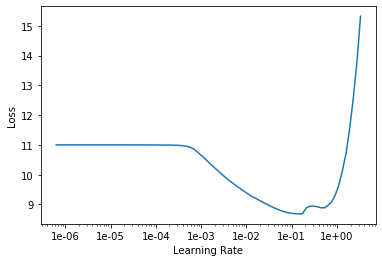

In [48]:
learn.recorder.plot()

In [49]:
lr = 3e-3
lr *= bs/48  # Scale learning rate by batch size

In [ ]:
#learn.unfreeze()
learn.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,3.230054,3.297531,0.552014,0.447986,27.045725,5:26:20
1,2.995877,3.269986,0.553188,0.446813,26.311113,5:39:31


Save the pretrained model and vocab:

In [18]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(mdl_path/lm_fns3[0], with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns3[1] + '.pkl'))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,3.712833,3.801982,0.689854,0.310145,44.789921,45:07
1,3.495445,3.612981,0.673845,0.326156,37.076435,44:49
2,3.416562,3.550838,0.667659,0.332342,34.842659,45:11
3,3.346702,3.473753,0.658722,0.341275,32.257648,45:09
4,3.269586,3.402409,0.649641,0.350360,30.036201,45:10
5,3.206794,3.321666,0.639204,0.360796,27.706499,45:08
6,3.124528,3.235740,0.627807,0.372192,25.425192,45:08
7,3.092082,3.157651,0.616111,0.383889,23.515293,45:11
8,2.963153,3.095485,0.606017,0.393983,22.097927,45:11
9,2.998470,3.079903,0.603129,0.396870,21.756315,45:09


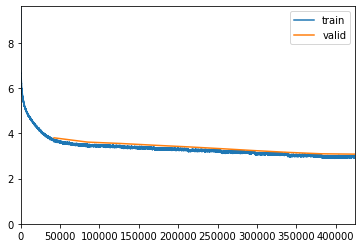

Better model found at epoch 0 with accuracy value: 0.31014543771743774.
Better model found at epoch 1 with accuracy value: 0.3261563181877136.
Better model found at epoch 2 with accuracy value: 0.3323418200016022.
Better model found at epoch 3 with accuracy value: 0.34127548336982727.
Better model found at epoch 4 with accuracy value: 0.3503599464893341.
Better model found at epoch 5 with accuracy value: 0.3607962131500244.
Better model found at epoch 6 with accuracy value: 0.3721919059753418.
Better model found at epoch 7 with accuracy value: 0.3838889002799988.
Better model found at epoch 8 with accuracy value: 0.393983393907547.
Better model found at epoch 9 with accuracy value: 0.3968702554702759.
CPU times: user 5h 51min 50s, sys: 1h 41min 8s, total: 7h 32min 59s
Wall time: 7h 31min 56s


In [17]:
%%time
learn.unfreeze()
wd = 0.01 
learn.fit_one_cycle(10, lr, wd=wd, moms=(0.8,0.7), 
                    callbacks=[ShowGraph(learn),
                               SaveModelCallback(learn.to_fp32(), monitor='accuracy', name='bestmodel_sp15_multifit')])

### Backward

nesse estágio ainda não treinei o backward

In [19]:
# data = load_data(path, f'{lang}_databunch_corpus2_100_sp15_multifit_bwd', bs=bs, backwards=True)

In [20]:
# config = awd_lstm_lm_config.copy()
# config['qrnn'] = True
# config['n_hid'] = 1550 #default 1152
# config['n_layers'] = 4 #default 3

In [21]:
# %%time
# perplexity = Perplexity()
# learn = language_model_learner(data, AWD_LSTM, config=config, drop_mult=0., pretrained=False, 
#                                metrics=[error_rate, accuracy, perplexity]).to_fp16()

CPU times: user 952 ms, sys: 68 ms, total: 1.02 s
Wall time: 1.02 s


In [22]:
# learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


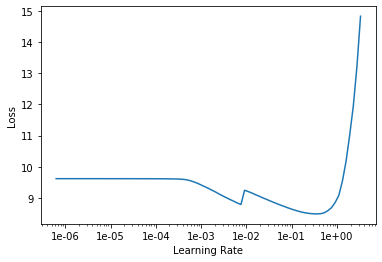

In [23]:
# learn.recorder.plot()

In [24]:
# lr = 3e-3
# lr *= bs/48  # Scale learning rate by batch size

# wd = 0.01

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,3.759265,3.812161,0.645454,0.354546,45.248158,45:15
1,3.524330,3.643459,0.632401,0.367599,38.223717,45:16
2,3.399805,3.569191,0.624596,0.375404,35.487923,45:14
3,3.358356,3.492392,0.615690,0.384309,32.864567,48:06
4,3.298991,3.423204,0.607334,0.392666,30.667429,44:30
5,3.230762,3.344130,0.598109,0.401891,28.335854,44:15
6,3.139510,3.259253,0.586869,0.413130,26.030067,44:16
7,3.123008,3.175821,0.575663,0.424338,23.946394,44:10
8,3.007710,3.114435,0.566360,0.433641,22.520712,44:10
9,2.955673,3.098413,0.563313,0.436688,22.162729,44:18


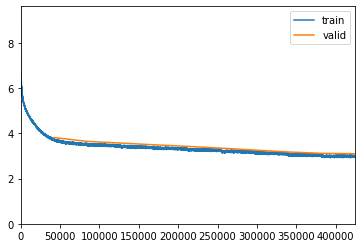

Better model found at epoch 0 with accuracy value: 0.35454609990119934.
Better model found at epoch 1 with accuracy value: 0.36759868264198303.
Better model found at epoch 2 with accuracy value: 0.3754040598869324.
Better model found at epoch 3 with accuracy value: 0.38430914282798767.
Better model found at epoch 4 with accuracy value: 0.39266595244407654.
Better model found at epoch 5 with accuracy value: 0.4018912613391876.
Better model found at epoch 6 with accuracy value: 0.4131302535533905.
Better model found at epoch 7 with accuracy value: 0.4243376851081848.
Better model found at epoch 8 with accuracy value: 0.43364080786705017.
Better model found at epoch 9 with accuracy value: 0.43668755888938904.
CPU times: user 5h 48min 48s, sys: 1h 42min 19s, total: 7h 31min 7s
Wall time: 7h 30min 9s


In [25]:
# %%time
# learn.unfreeze()
# learn.fit_one_cycle(10, lr, wd=wd, moms=(0.8,0.7), 
#                     callbacks=[ShowGraph(learn),
#                                SaveModelCallback(learn.to_fp32(), monitor='accuracy', name='bestmodel_sp15_multifit_bwd')])

In [26]:
# mdl_path = path/'models'
# mdl_path.mkdir(exist_ok=True)
# learn.to_fp32().save(mdl_path/lm_fns3_bwd[0], with_opt=False)
# learn.data.vocab.save(mdl_path/(lm_fns3_bwd[1] + '.pkl'))

## Generate fake texts

**Note**: the architecture used for our Portuguese LM is based on 4 QRNN with about 46 millions of parameters. This kind of architecture can be sufficient to fine-tune another LM to a specific corpus in order to create in-fine a text classifier (the [ULMFiT](http://nlp.fast.ai/category/classification.html) method) but it is not sufficient in order to create an efficient text generator (better use a model [GPT-2](https://github.com/openai/gpt-2) or [BERT](https://github.com/google-research/bert)). More, the SentencePiece tokenizer used in this notebook implements subword units (e.g., byte-pair-encoding (BPE) [Sennrich et al.]) and unigram language model [Kudo.]) that can generate caracters from its vocabulary instead of words. 

In [9]:
%%time
data = load_data(path, f'{lang}_databunch_corpus2_100_sp15_multifit', bs=bs)

CPU times: user 3.11 s, sys: 1.81 s, total: 4.92 s
Wall time: 13.7 s


In [10]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [11]:
# LM without pretraining
learn = language_model_learner(data, AWD_LSTM, config=config, pretrained=False)

In [12]:
# LM pretrained in English
learn_en = language_model_learner(data, AWD_LSTM, pretrained=True)

In [13]:
# LM pretrained in french
learn_pt = language_model_learner(data, AWD_LSTM, config=config, pretrained_fnames=lm_fns3)

In [14]:
TEXT = "Nadal venceu o torneio" # original text
N_WORDS = 100 # number of words to predict following the TEXT
N_SENTENCES = 1 # number of different predictions

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Nadal venceu o torneio ▁comprar ▁relevante ▁cordas mila ▁lutadores ▁assumido fos ল velmente ▁conjunto ▁american ▁lentamente ▁empregada ▁extra เ anfitriã ⵙ ▁gonzaga ⊂ ̌ coli ▁feijão gi ▁útil ▁notável evolution my 20 ▁gen ▁subespécie ổ ▁cachoeira ▁natal nik ▁jornal ▁cartões ▁desportivo ▁grega ỏ sa ▁azulejos ▁habitat ▁energia fc ▁fazê 68 ▁reencontra ▁humorístico ▁mitchell ▁kris organiz ▁designar ▁castro ▁cerâmica ▁bob burg dos ▁usualmente ▁pessoas ▁principais ▁saudita ▁rom ▁escolhido ▁abandonou ▁patrimônio rid ib ▁ventos ▁banda ▁fim ▁dinamarquesa ን ▁divididos ▁apropriado carna ▁graves ▁vir ▁fm ខ far ▁cbf 提 wel ▁aclamação ├ 童 ▁vinda ▁alusão mun ▁bacia 工 ▁arrenda ▁biológica ▁marginal ▁cheio hí ▁chicago ▁daí 화 ▁parceira


In [15]:
TEXT = "Nadal venceu o torneio" # original text
N_WORDS = 100 # number of words to predict following the TEXT
N_SENTENCES = 1 # number of different predictions

print("\n".join(learn_en.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Nadal venceu o torneio into the " big - screen " . a " ' cop - man ' game , " " a first - time " , is a one - game , game - to - day play . " a " as a game for the " bad man " , " you - do - it - you - do - it - me - to - do " game , " the first game " , is " the first game in the world " . a game in all four game , " the game " ,


In [16]:
TEXT = "Nadal venceu o torneio" # original text
N_WORDS = 100 # number of words to predict following the TEXT
N_SENTENCES = 1 # number of different predictions

print("\n".join(learn_pt.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Nadal venceu o torneio ▁xxmaj ▁ ▁oficial ▁de ▁ , ▁em ▁seu ▁segundo ▁dia ▁no ▁dia ▁da ▁xxmaj ▁copa ▁xxmaj ▁ master s , ▁em ▁xxmaj ▁ las ▁xxmaj ▁vegas , ▁em ▁15 ▁de ▁xxmaj ▁abril ▁de ▁2016. ▁xxmaj ▁durante ▁a ▁temporada , ▁foi ▁o ▁primeiro ▁título ▁da ▁liga , ▁vencendo ▁o ▁xxmaj ▁ s pur s ▁por ▁9 zo s ▁por ▁3 ▁a ▁0 . ▁o ▁campeão ▁foi ▁o ▁ , ▁da ▁xxmaj ▁copa ▁do ▁xxmaj ▁mundo ▁de ▁xxmaj ▁ ty r rell , ▁onde ▁o ▁título ▁passou ▁a ▁ser ▁xxmaj ▁ s qua d . ▁a ▁xxup ▁ m l s ▁é
